In [7]:
#CI 492
#Digital Pathology
#By: Shuyi Gu, Joe Amon 
#Revised by Shuyi Gu 2019-12-23
#Testing Framework
#Prestine version for binary classification training with LeNet 5 Architecture
#We may use this training framework, change code in get_model(), try different types of CNN architecture: VGG, AlexNet
# GoogleNet and ResNet

In [34]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Add, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
import cv2
import scipy
import os
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# dimensions of our images
img_width, img_height = 50, 50
if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

#THRESHOLD = 0.95

In [24]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# dimensions of our images
img_width, img_height = 50, 50
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

THRESHOLD = 0.5


K.set_image_data_format('channels_last')
K.set_learning_phase(1)


def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape=(64, 64, 3), classes=6):
# Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = Lambda(lambda x: x * 1./255., input_shape=input_shape, output_shape=input_shape)(X_input)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [25]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
        conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
        x = inputs
        if conv_first:
            x = conv(x)
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
        else:
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
            x = conv(x)
        return x

def resnet_v1(input_shape):
        num_filters = 16
        num_res_blocks = int((20 - 2) / 6)

        inputs = Input(shape=input_shape)
        x = resnet_layer(inputs=inputs)
        y = x
        # Instantiate the stack of residual units
        for stack in range(3):
            for res_block in range(num_res_blocks):
                strides = 1

                if stack > 0 and res_block == 0:
                    y = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 strides=strides)
                    y = resnet_layer(inputs=y,
                                 num_filters=num_filters,
                                 activation=None)
                if stack > 0 and res_block == 0:
                    x = resnet_layer(inputs=x,
                                     num_filters=num_filters,
                                     kernel_size=1,
                                     strides=strides,
                                     activation=None,
                                     batch_normalization=False)
                x = keras.layers.add([x, y])
                x = Activation('relu')(x)
            num_filters *= 2

        x = AveragePooling2D(pool_size=8)(x)
        y = Flatten()(x)
        outputs = Dense(1,
                        activation='softmax',
                        kernel_initializer='he_normal')(y)

        # Instantiate model.
        model = Model(inputs=inputs, outputs=outputs)

        return model

In [26]:
def get_res_model():
    model = resnet_v1((50,50,3))

    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

        # load model
    return model

In [39]:
def get_res50_model():
    model = ResNet50((50,50,3),1)

    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

        # load model
    return model

In [27]:
#Helper functions for batch-wise
def matthews_correlation(y_true, y_pred):
    """Matthews correlation metric.
# Aliases

    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)



In [28]:
epochs = 20
BASE_DIR = '../'
batch_size = 32

In [29]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    #model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])

    return model

In [30]:
model = get_model()
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
activation_36 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 64)        18496     
___________________________

In [31]:
model2 = get_res_model()
print(model2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 50, 50, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_15 (Batc (None, 50, 50, 16)   64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 50, 50, 16)   0           batch_normalization_v1_15[0][0]  
__________________________________________________________________________________________________
add_27 (Ad

In [40]:
model3 = get_res50_model()
print(model3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 50, 50, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 56, 56, 3)    0           lambda_4[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 25, 25, 64)   9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (

In [20]:
def Convert_helper(): # - By Joe Amon
        eo_path = './data/eosinophil'
        non_eo_path = './data/non-eosinophil'
        data_x = []  # images (4000,50,50,3)
        data_y = []  # labels (4000,)
        total_files = 2000; # Get 2000 random files from both dirs

        # for files in eo_path dir
        eo_folder = os.listdir(eo_path)
        np.random.shuffle(eo_folder);
        for i, img in enumerate(eo_folder):
            if i == total_files:
                break;
            img_path = eo_path + "/" + img
            eo_image = image.load_img(img_path, target_size=(img_width, img_height))
            eo_image = image.img_to_array(eo_image)
            data_x.append(eo_image)
            data_y.append(1)

        # for files in non_eo_path dir
        non_eo_folder = os.listdir(non_eo_path)
        np.random.shuffle(eo_folder);
        for i, img in enumerate(non_eo_folder):
            if i == total_files:
                break;
            img_path = non_eo_path + "/" + img
            non_eo_image = image.load_img(img_path, target_size=(img_width, img_height))
            non_eo_image = image.img_to_array(non_eo_image)
            data_x.append(non_eo_image)
            data_y.append(0)

        # randomize rows of data_x and data_y the same way
        p = np.random.permutation(len(data_y))

        return np.array(data_x)[p], np.array(data_y)[p]
    
def test_binary_lenet():
    data_x, data_y = Convert_helper()
    
    
    #for i in range(0,s):
    #    c_data_x_test = data_x_split[i]
    #    c_data_y_test = data_y_split[i]
    #    c_data_x_train_list = data_x_split[:i] + data_x_split[i+1:]
    #    c_data_y_train_list = data_y_split[:i] + data_y_split[i+1:]
    #    c_data_x_train = concatination_helper(c_data_x_train_list)
    #    c_data_y_train = concatination_helper(c_data_y_train_list)
        
    model1 = get_model()

        # fits the model on batches
    history = model1.fit(
            data_x,
            data_y,
            validation_split=0.2,
            epochs=epochs,
            shuffle=True,
            batch_size=batch_size)

    model1.save_weights('binary_model_test.h5')
    return history
        
def concatination_helper(data_list): #DELETE
    result = data_list[0]
    for i in range(1, len(data_list)):
        result = np.concatenate((result, data_list[i]),axis=0)
    return result 
        
def split_helper(data, s):#DELETE
    result = []
    s_size = data.shape[0]//s
    print(s_size)
    for i in range(0,s):
        if i!= s-1:
            current = data[(i*s_size):((i+1)*s_size),:]
            
            result.append(current)
            
        else:
            current = data[i*s_size:,:]
            result.append(current)
    return result

 

In [21]:
def test_binary_resnet():
    data_x, data_y = Convert_helper()
    
    
    #for i in range(0,s):
    #    c_data_x_test = data_x_split[i]
    #    c_data_y_test = data_y_split[i]
    #    c_data_x_train_list = data_x_split[:i] + data_x_split[i+1:]
    #    c_data_y_train_list = data_y_split[:i] + data_y_split[i+1:]
    #    c_data_x_train = concatination_helper(c_data_x_train_list)
    #    c_data_y_train = concatination_helper(c_data_y_train_list)
        
    model1 = get_res_model()

        # fits the model on batches
    history = model1.fit(
            data_x,
            data_y,
            validation_split=0.2,
            epochs=epochs,
            shuffle=True,
            batch_size=batch_size)

    model1.save_weights('binary_res_model_test.h5')
    return history
        

In [41]:
def test_binary_resnet50():
    data_x, data_y = Convert_helper()
    
    
    #for i in range(0,s):
    #    c_data_x_test = data_x_split[i]
    #    c_data_y_test = data_y_split[i]
    #    c_data_x_train_list = data_x_split[:i] + data_x_split[i+1:]
    #    c_data_y_train_list = data_y_split[:i] + data_y_split[i+1:]
    #    c_data_x_train = concatination_helper(c_data_x_train_list)
    #    c_data_y_train = concatination_helper(c_data_y_train_list)
        
    model1 = get_res50_model()

        # fits the model on batches
    history = model1.fit(
            data_x,
            data_y,
            validation_split=0.2,
            epochs=epochs,
            shuffle=True,
            batch_size=batch_size)

    model1.save_weights('binary_res50_model_test.h5')
    return history

In [ ]:
#history = test_binary_lenet()

In [23]:

history = test_binary_resnet()

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 105s 33ms/sample - loss: 7.9308 - acc: 0.5044 - val_loss: 8.2644 - val_acc: 0.4825
Epoch 2/20
3200/3200 [==============================] - 112s 35ms/sample - loss: 7.9106 - acc: 0.5044 - val_loss: 8.2559 - val_acc: 0.4825
Epoch 3/20
3200/3200 [==============================] - 115s 36ms/sample - loss: 7.9053 - acc: 0.5044 - val_loss: 8.2526 - val_acc: 0.4825
Epoch 4/20
 128/3200 [>.............................] - ETA: 1:45 - loss: 8.3472 - acc: 0.4766

KeyboardInterrupt: 

In [42]:
#history = test_binary_lenet()
history = test_binary_resnet50()

Train on 3200 samples, validate on 800 samples
Epoch 1/20


KeyboardInterrupt: 

In [28]:
history_keys = list(history.history.keys())
key_train_precision = history_keys[2]
key_train_recall = history_keys[3]
key_test_precision = history_keys[6]
key_test_recall = history_keys[7]


train_precision = np.array(history.history[key_train_precision])
train_recall = np.array(history.history[key_train_recall])
test_precision = np.array(history.history[key_test_precision])
test_recall = np.array(history.history[key_test_recall])

train_f_measure = (2*train_precision*train_recall)/(train_precision+train_recall)
test_f_measure = (2*test_precision*test_recall)/(test_precision+test_recall)


In [29]:
train_f_measure

array([0.5719877 , 0.6323238 , 0.6484211 , 0.71475214, 0.7296665 ,
       0.7453341 , 0.7427198 , 0.7580838 , 0.7631579 , 0.7662377 ,
       0.782246  , 0.7816647 , 0.7914148 , 0.8052026 , 0.81177896,
       0.8183206 , 0.8187385 , 0.8154981 , 0.83662146, 0.83585775],
      dtype=float32)

In [30]:
test_f_measure

array([0.67953026, 0.33716476, 0.6424731 , 0.73574144, 0.74916387,
       0.7318236 , 0.70959896, 0.73493975, 0.71969706, 0.73762375,
       0.7633069 , 0.72383356, 0.7392344 , 0.71839803, 0.77165353,
       0.704     , 0.7176913 , 0.7369697 , 0.74092007, 0.7565632 ],
      dtype=float32)

In [31]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'precision_3', 'recall_2', 'val_loss', 'val_acc', 'val_precision_3', 'val_recall_2'])


In [32]:
type(history)

tensorflow.python.keras.callbacks.History

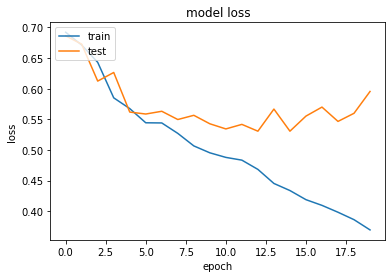

In [33]:
def plot_learning_curve(history):
    #accuracy curve
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc']) 
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    #precision/recall curve
    plt.plot(train_precision)
    plt.plot(train_recall)
    plt.plot(test_precision)
    plt.plot(test_recall)
    plt.title('Precision Recall Diagram')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_precision', 'train_recall','test_precision','test_recall'], loc='upper left')
    plt.savefig('./precision_recall_curve.png')
    plt.clf()
    
    #f_measure curve
    plt.plot(train_f_measure)
    plt.plot(test_f_measure)

    plt.title('F Measure Diagram')
    plt.ylabel('f-measure')
    plt.xlabel('epoch')
    plt.legend(['train_f_measure', 'test_f_measure'], loc='upper left')
    plt.savefig('./F_Measure.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

plot_learning_curve(history)

# Accuracy

In [8]:
#Placeholder, will use later
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data


NameError: name 'X_test' is not defined

# Experiment with AutoGluon: AutoML Toolkit for Deep Learning

In [1]:
import autogluon as ag
from autogluon import ImageClassification as task


In [2]:
dataset = task.Dataset('./data')

In [ ]:
#time_limits = 10 * 60 # 10mins
#classifier = task.fit(dataset, time_limits=time_limits, ngpus_per_trial=1)
classifier = task.fit(dataset,
                      epochs=10,
                      ngpus_per_trial=1,
                      verbose=True)

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


{'dataset': Dataset ImageFolderDataset
    Number of datapoints: 6266
    Root location: ./data, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.SGD object at 0x139c1c320>, 'lr_scheduler': 'cosine', 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 0, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': False, 'task_id': 0}
{'dataset': Dataset ImageFolderDataset
    Number of datapoints: 6266
    Root location: ./data, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.SGD object at 0x11ff80a58>, 'lr_scheduler': 'cosine', 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 0, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'verbose': True, 'num_workers': 4, 'hybridize': True, 'final_fit': False, 'task_id': 1}


In [ ]:
print('Top-1 val acc: %.3f' % classifier.results['best_reward'])
